Hi Team, I'm Santosh.

Estimated reading time: 9 minute


Part 1: Wrangling the Data

Reading the data, and doing some basic data exploration and cleaning.

In [38]:
# Basic imports to get things going
import pandas as pd
import time
import datetime
import statsmodels
import matplotlib.pyplot as plt

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [39]:
# read the parquet file
df = pd.read_parquet("data.parquet", engine='fastparquet')

# Lets see what we have
df.head()

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27


<AxesSubplot: xlabel='time'>

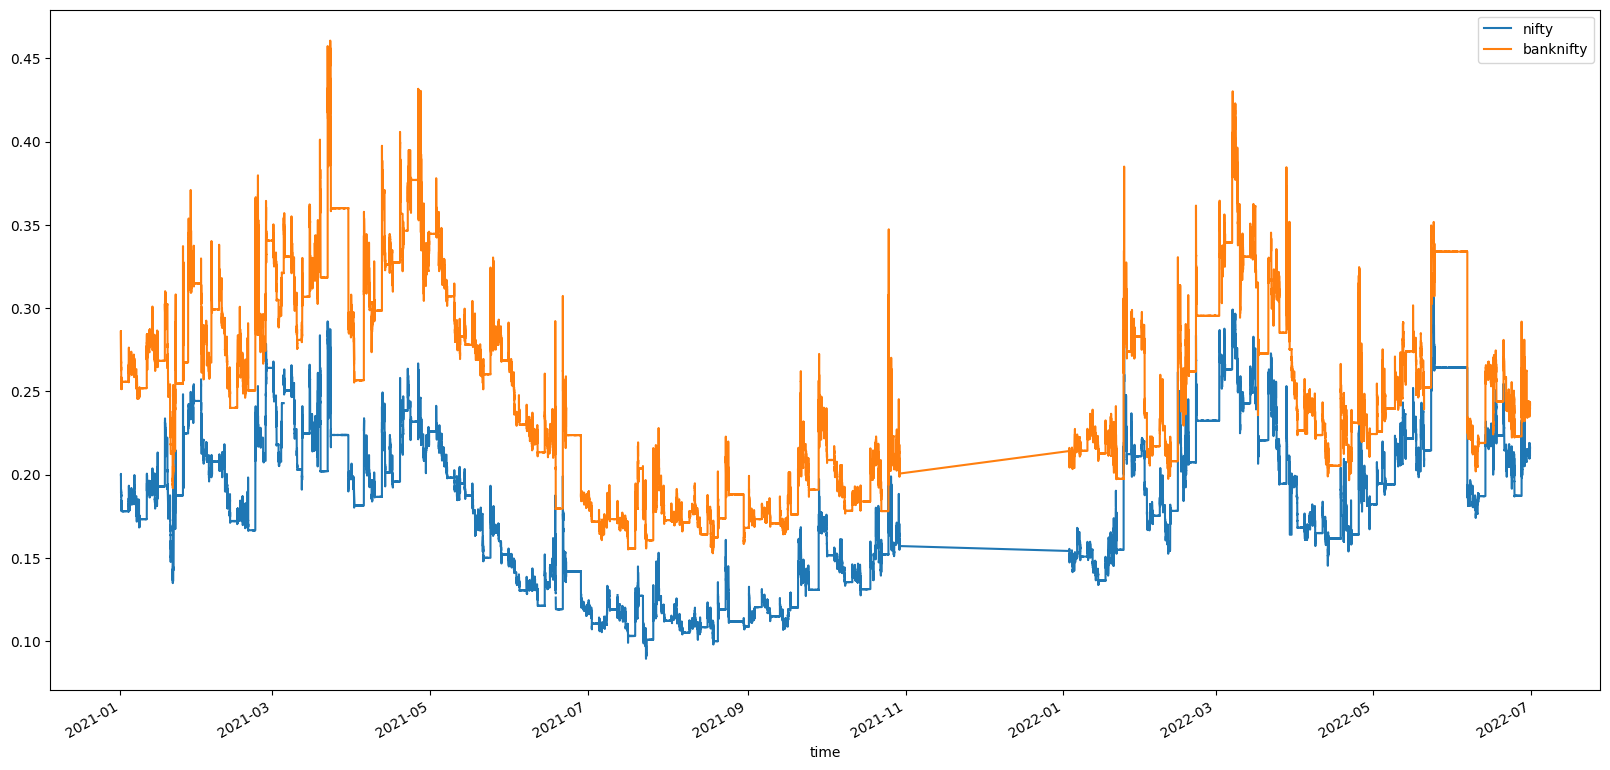

In [40]:
'''
I'm more of a visual person, so let's plot the data and see what we have
'''

# plot the data nifty, banknifty
df.plot( y=['nifty', 'banknifty'], figsize=(20,10))

Horizontal lines in the graph shows there are periods where the IV is stagnent.
Which doesn't normally happen. 

Post this, converted the data to csv to have a look at the data in excel.

Here are the high level observations:
1. Post trading hours data is present in the data set.
2. Non trading days(weekends, holidays) data is present in the data set.
3. There are periods where the IV is stagnent(apart from non trading day). 

Let's clean this up a bit.

In [41]:
# Doing this to convert the time index to a column
df = df.reset_index()

In [42]:
# split the time column into date and time
# easier this way to clean things up on date level and time level
df['date'] = df['time'].dt.date
df['time'] = df['time'].dt.time

In [43]:
# remove the non trading hours data points

# trim the df to include the data between 9:15 to 15:30
df = df[(df['time'] >= datetime.time(9, 15)) & (df['time'] <= datetime.time(15, 30))]

In [44]:
'''
To remove the non trading days, we could -

1. remove the weekends, remove the holidays 
2. remove the days where there's no change in IV i.e standard deviation is 0

I'm going to go with option 2, easier to implement
'''

"\nTo remove the non trading days, we could -\n\n1. remove the weekends, remove the holidays \n2. remove the days where there's no change in IV i.e standard deviation is 0\n\nI'm going to go with option 2, easier to implement\n"

In [45]:
# remove the non trading days
# if all the values for a day are same in nifty and banknifty, then it is a non trading day
df = df[df.groupby('date')['nifty'].transform('std') != 0]

In [46]:
# reset the index for one last time as we have removed some rows
df = df.reset_index(drop=True)

In [47]:
# Filling in missing values for nifty and banknifty IV

# fill the missing values with the average of the previous and next values
# we could do a simple forward fill too, but this is just a tiny bit more accurate
df['nifty'] = df['nifty'].fillna((df['nifty'].shift() + df['nifty'].shift(-1))/2)
df['banknifty'] = df['banknifty'].fillna((df['banknifty'].shift() + df['banknifty'].shift(-1))/2)

Part 2: The Z Score way

In [48]:
# Lets look at the correlation between nifty and banknifty
print(df['nifty'].corr(df['banknifty']))

0.8922877906288749


In [49]:
# Calculate the spread as mentioned
df['spread'] = df['banknifty'] - df['nifty']

In [50]:
'''
calculate the Z score

z_score = (spread - mean)/std

Calculating the mean and std for the entire data set is not a good idea,
as we would be using the future data to calculate the mean and std

So, we will use the rolling mean and rolling std

Setting the rolling window to 375, as we have 375 data points per day
'''

rolling_window = 375

df['mean'] = df['spread'].rolling(rolling_window).mean()
df['std'] = df['spread'].rolling(rolling_window).std()
df['zscore'] = (df['spread'] - df['mean'])/df['std']

# fill the missing values with 0
df['zscore'] = df['zscore'].fillna(0)

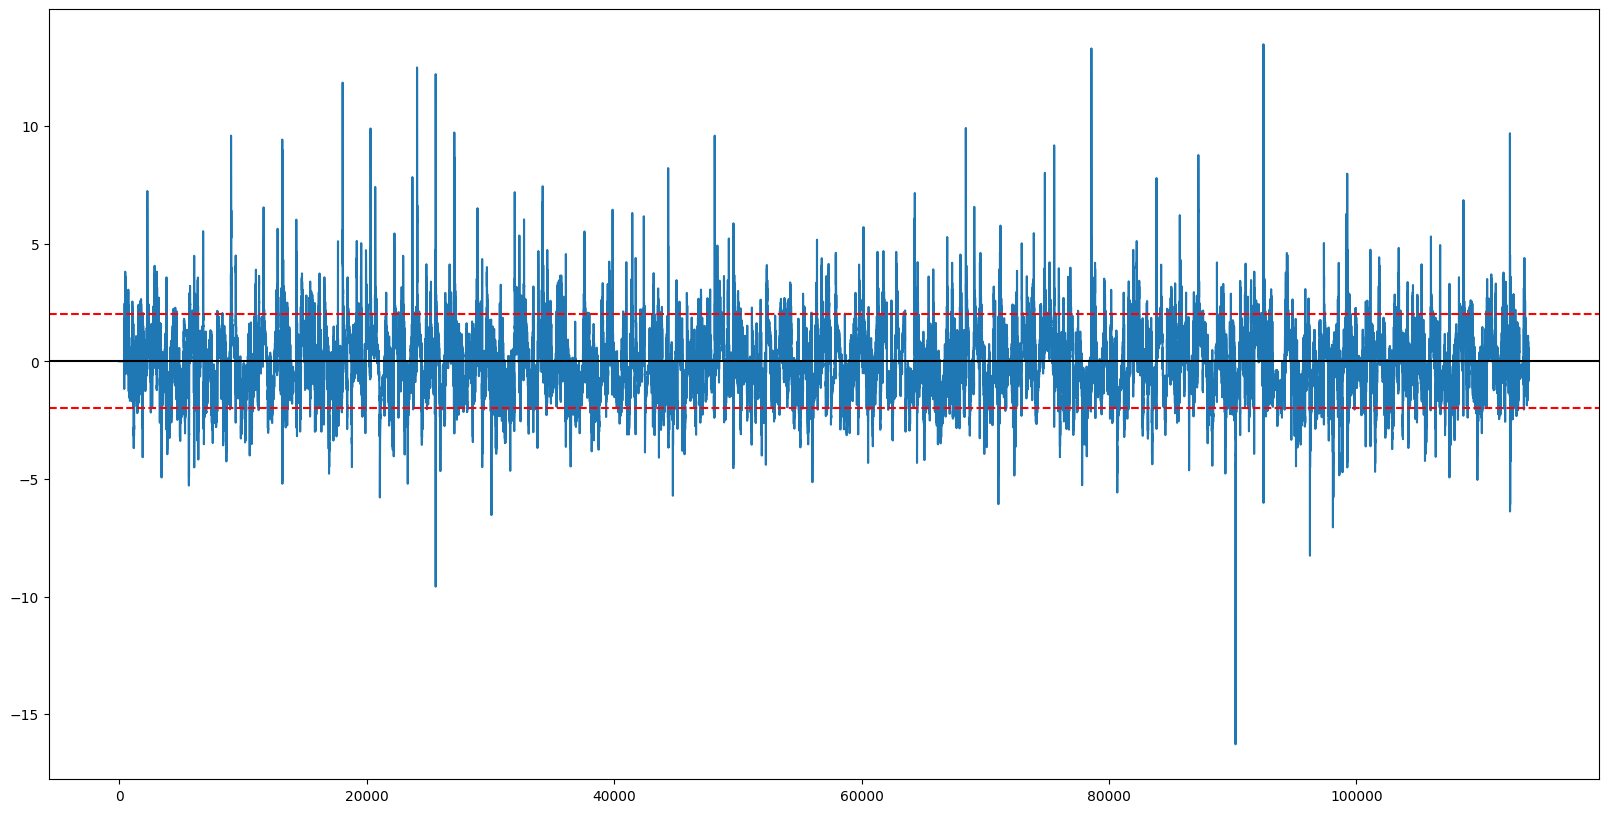

In [61]:
# print the zscore
df['zscore'].plot(figsize=(20,10))

plt.axhline(0, color='black')

# plot breaking line at 5 and -5
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')

This feels wrong.

So many occurences of of z score being greater than 5 and less than -5.

In [52]:
# print the top3 rows where the zscore is greater than 5
df[(df['zscore'] > 5) | (df['zscore'] < -5)].head(10)

,time,banknifty,nifty,tte,date,spread,mean,std,zscore
2256,09:15:00,0.272410,0.181029,17,2021-01-11,0.091382,0.077006,0.002244,6.407541
2257,09:16:00,0.277441,0.182924,17,2021-01-11,0.094517,0.077044,0.002414,7.239189
2258,09:17:00,0.276183,0.184308,17,2021-01-11,0.091874,0.077076,0.002528,5.854732
2263,09:22:00,0.274444,0.182855,17,2021-01-11,0.091589,0.077181,0.002835,5.082979
2264,09:23:00,0.275660,0.182678,17,2021-01-11,0.092981,0.077212,0.002941,5.362471
5616,15:07:00,0.227069,0.191960,7,2021-01-21,0.035110,0.058316,0.004395,-5.279692
6768,09:15:00,0.370916,0.243594,28,2021-01-28,0.127321,0.097709,0.005354,5.530958
9024,09:15:00,0.278537,0.198506,20,2021-02-05,0.080031,0.062560,0.002282,7.655345
9025,09:16:00,0.288119,0.200347,20,2021-02-05,0.087773,0.062637,0.002620,9.592181
9026,09:17:00,0.289436,0.200545,20,2021-02-05,0.088891,0.062712,0.002949,8.878654


The standard deviation in the spread is so small that the z score gets out of bound easily.

Part 3: The Rolling way

Instead of looking at the minute level data to enter, let's use moving average on the spread to enter 

In [65]:
df2 = df.copy()

# remove the columns that are not needed
df2 = df2.drop(['mean', 'std', 'zscore', ], axis=1)

# choosing the rolling window to be 120 as 120 points makes 2 hours
# 

df2['mean_120'] = df2['spread'].rolling(120).mean()
df2['mean_365'] = df2['spread'].rolling(365).mean()

df2['std_365'] = df2['spread'].rolling(365).std()

df2['zscore'] = (df2['mean_120'] - df2['mean_365'])/df2['std_365']


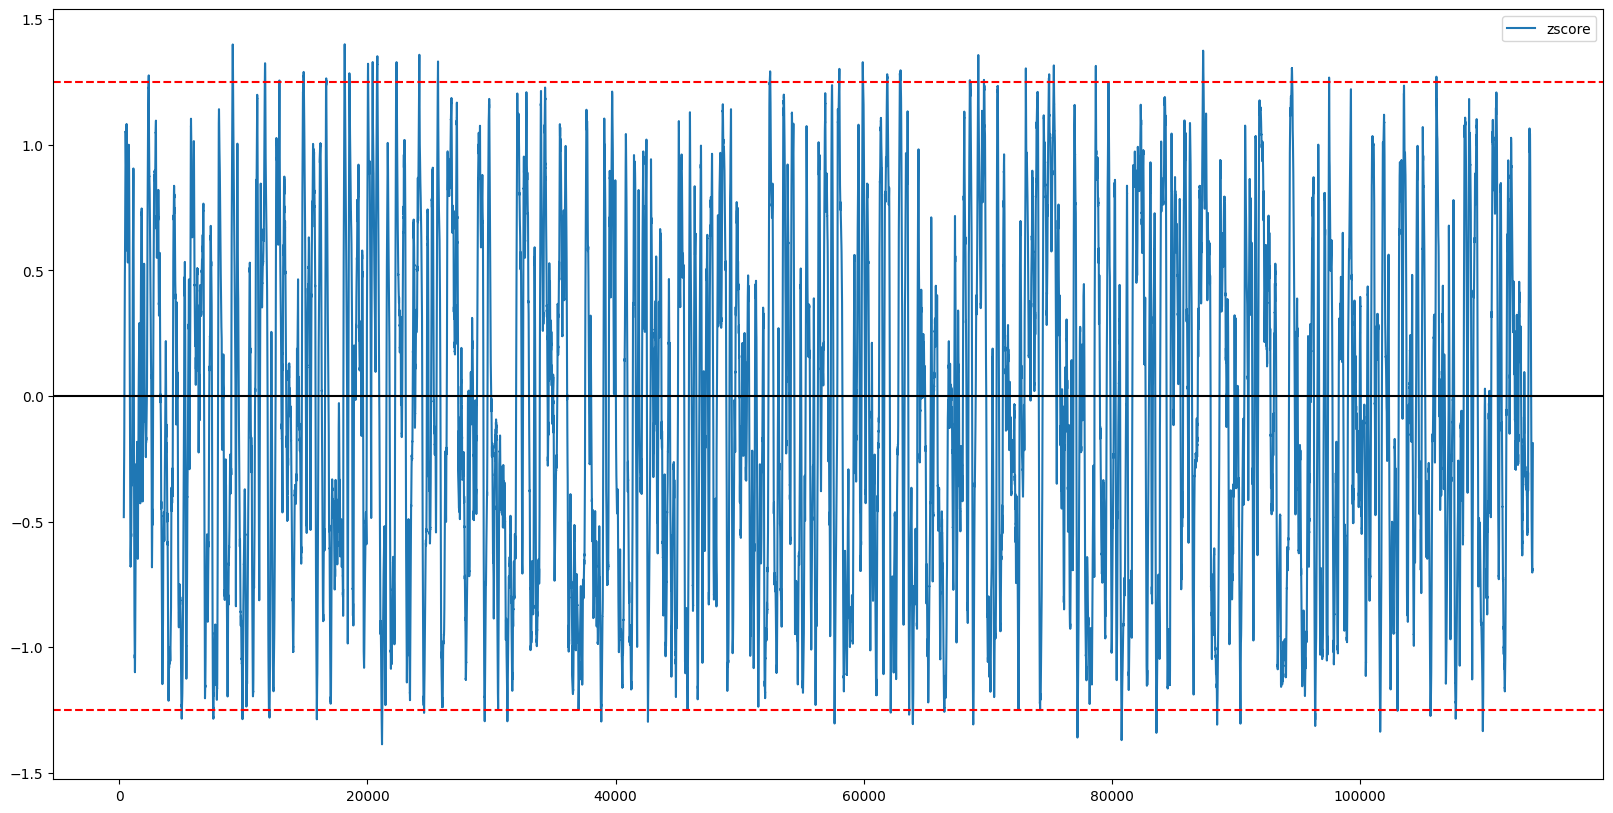

In [66]:
# plot the zscore
df2.plot(y=['zscore',], figsize=(20,10))
plt.axhline(0, color='black')

# plot breaking line at 5 and -5
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1.25, color='red', linestyle='--')

<AxesSubplot: >

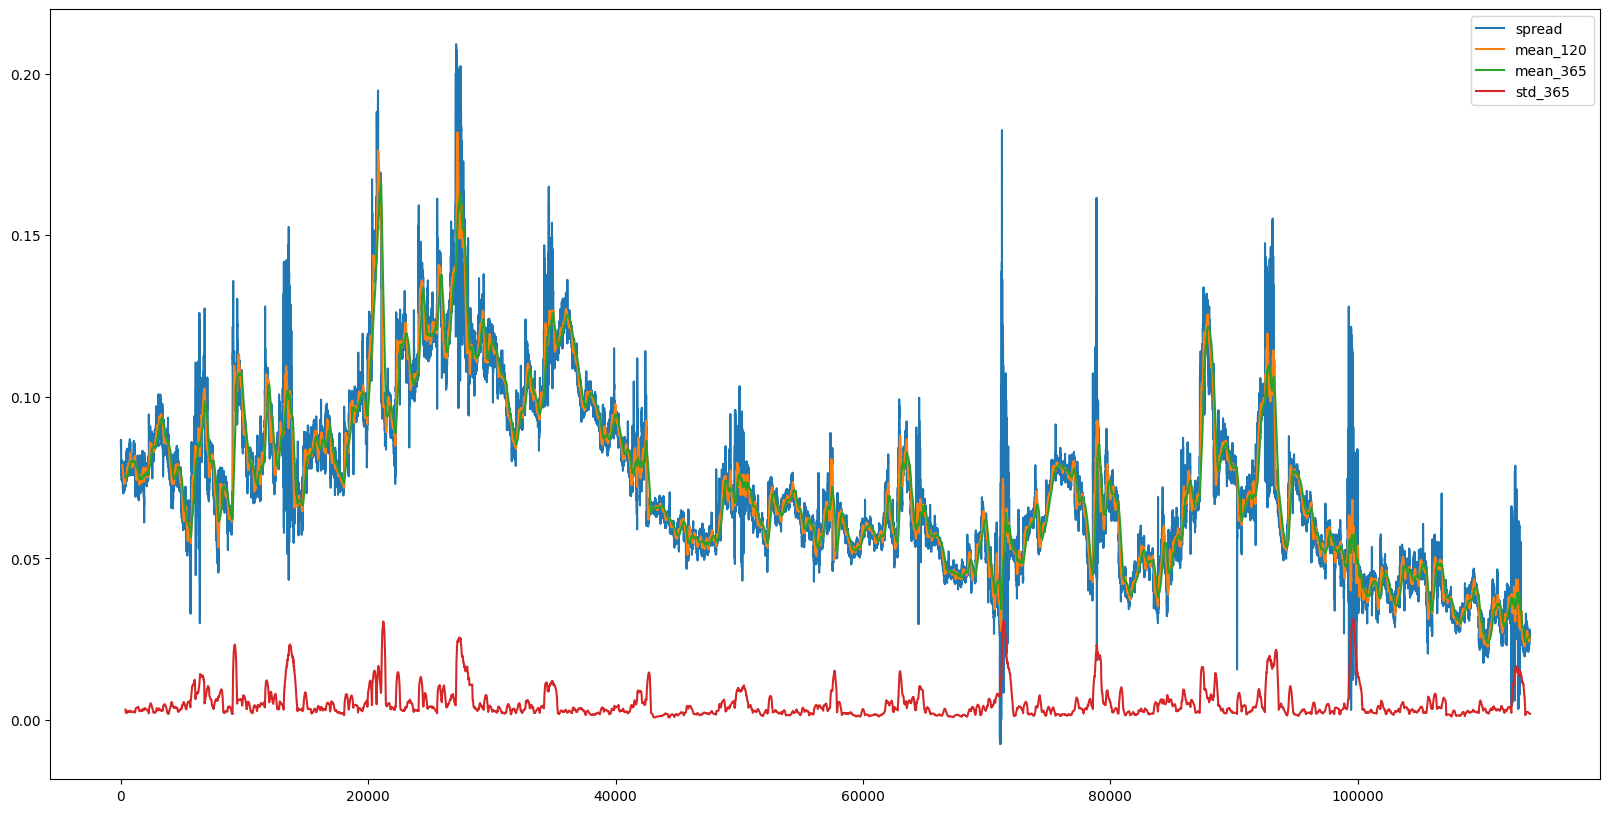

In [67]:
# plot the spread, mean_30 and mean_120, std_120
df2.plot(y=['spread', 'mean_120', 'mean_365', 'std_365'], figsize=(20,10))

In [56]:
'''
Trading Logic

Enter the trade when the zscore is greater than 1.25 or less than -1.25

Not sure how the Pnl logic works.
According to the notion document,

p/l=spread*(tte)^0.7

2 questions here -
1. The unit of tte, does it have to be in days or ratio of time left in month or something else?
2. The spread is never negative, the smallest value of spread is 0.0205120, 
    so by this formula the pnl can never be negative. Doesn't feel right.

'''

2404


<AxesSubplot: >

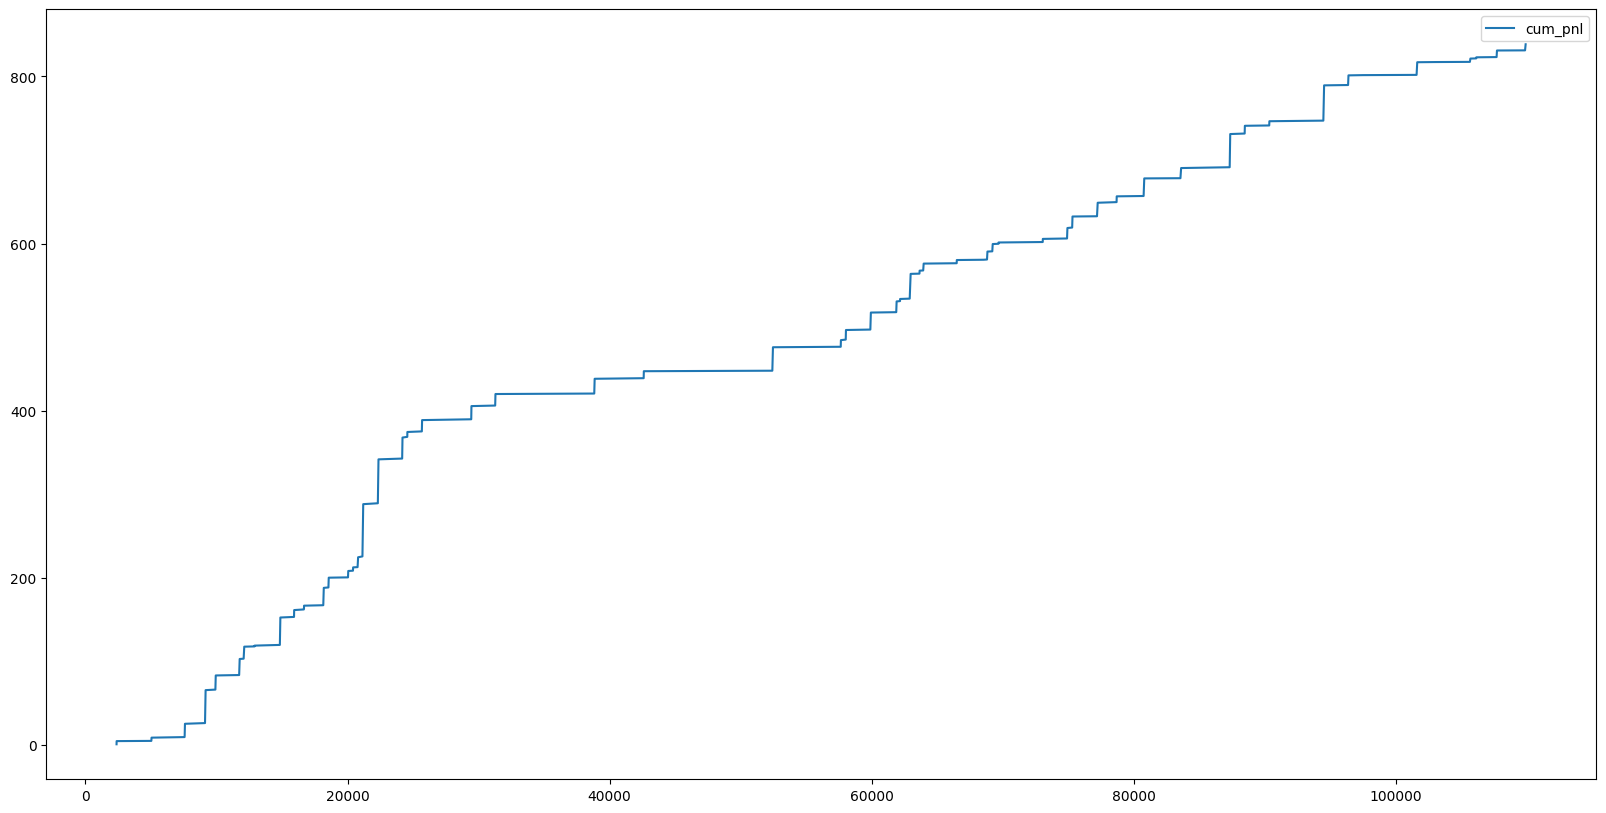

In [68]:
trade_df = df2[(df2['zscore'] > 1.25) | (df2['zscore'] < -1.25)]

# p/l=spread*(tte)^0.7
trade_df['pnl'] = trade_df['spread'] * (trade_df['tte']**0.7)

# cumulative pnl    
trade_df['cum_pnl'] = trade_df['pnl'].cumsum()

# plot the pnl
trade_df.plot(y='cum_pnl', figsize=(20,10))

In [69]:
# sharpe ratio
sharpe_ratio = trade_df['pnl'].mean()/trade_df['pnl'].std() * (252**0.5)

# max drawdown
trade_df['max_pnl'] = trade_df['cum_pnl'].cummax()
trade_df['drawdown'] = trade_df['cum_pnl'] - trade_df['max_pnl']
max_drawdown = trade_df['drawdown'].min()

print("Sharpe Ratio: ", sharpe_ratio)
print("Max Drawdown: ", max_drawdown)

Sharpe Ratio:  31.699386556175103
Max Drawdown:  0.0


Absurd Sharpe ratio (only if it were true)
Absurd drawdown numbers

Either I have wrong somewhere or the data is not right.

Either way wiould love to hear your thoughts on this and how to improve this.

Misceallaneous:

Read this only if you have spare time.

In [ ]:
'''
During the exploration phase, 
I was just plotting the data and noticed something
'''

<AxesSubplot: >

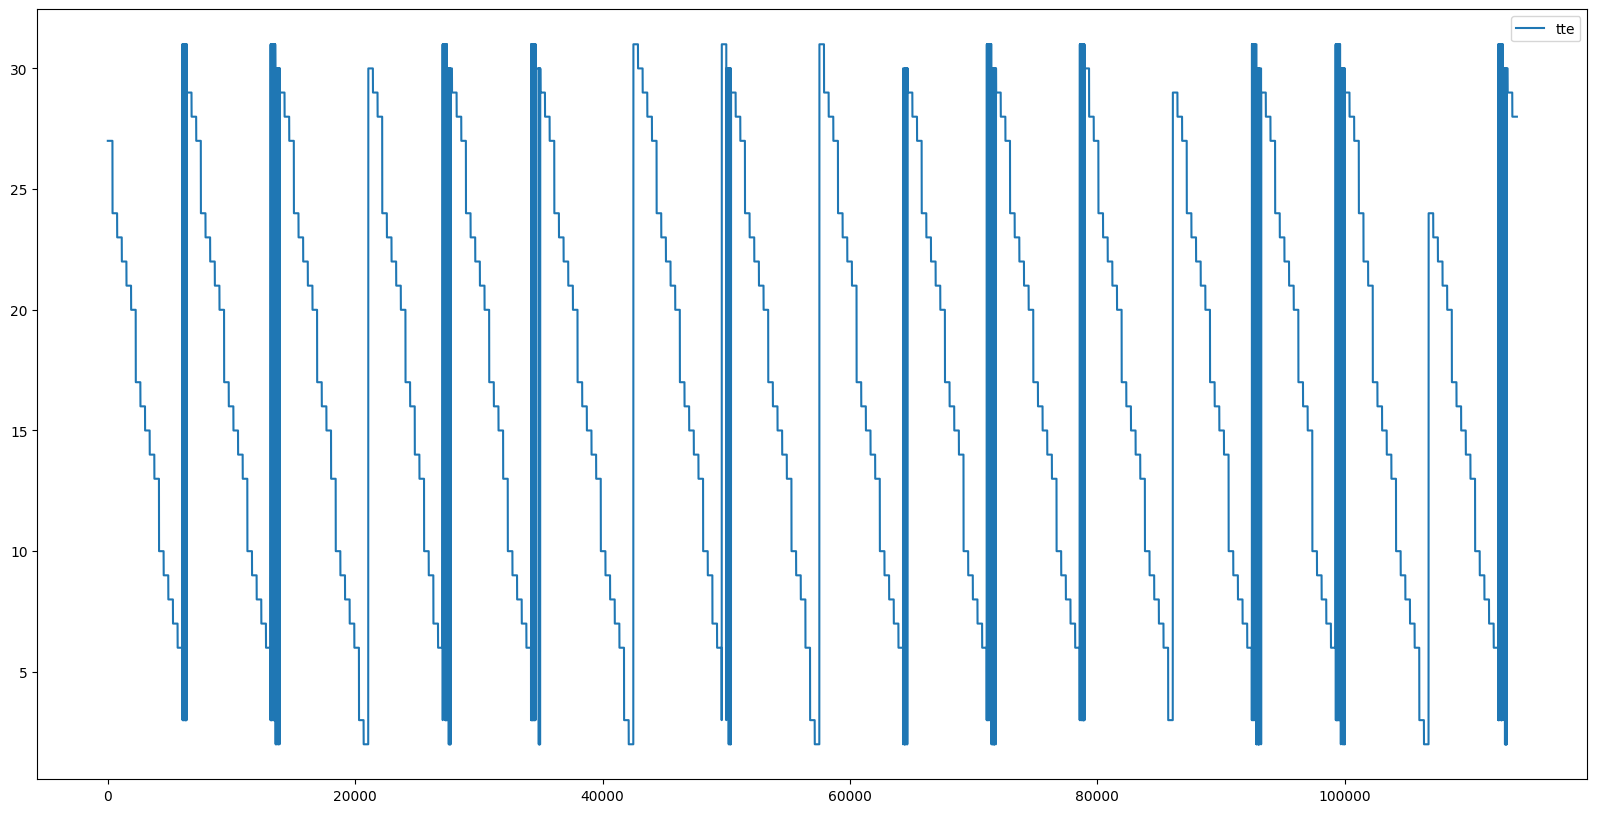

In [70]:
# plot the tte
df.plot(y='tte', figsize=(20,10))

In [ ]:
'''
The vertical lines looks awfully thick
wondering what is going on there

'''

<AxesSubplot: >

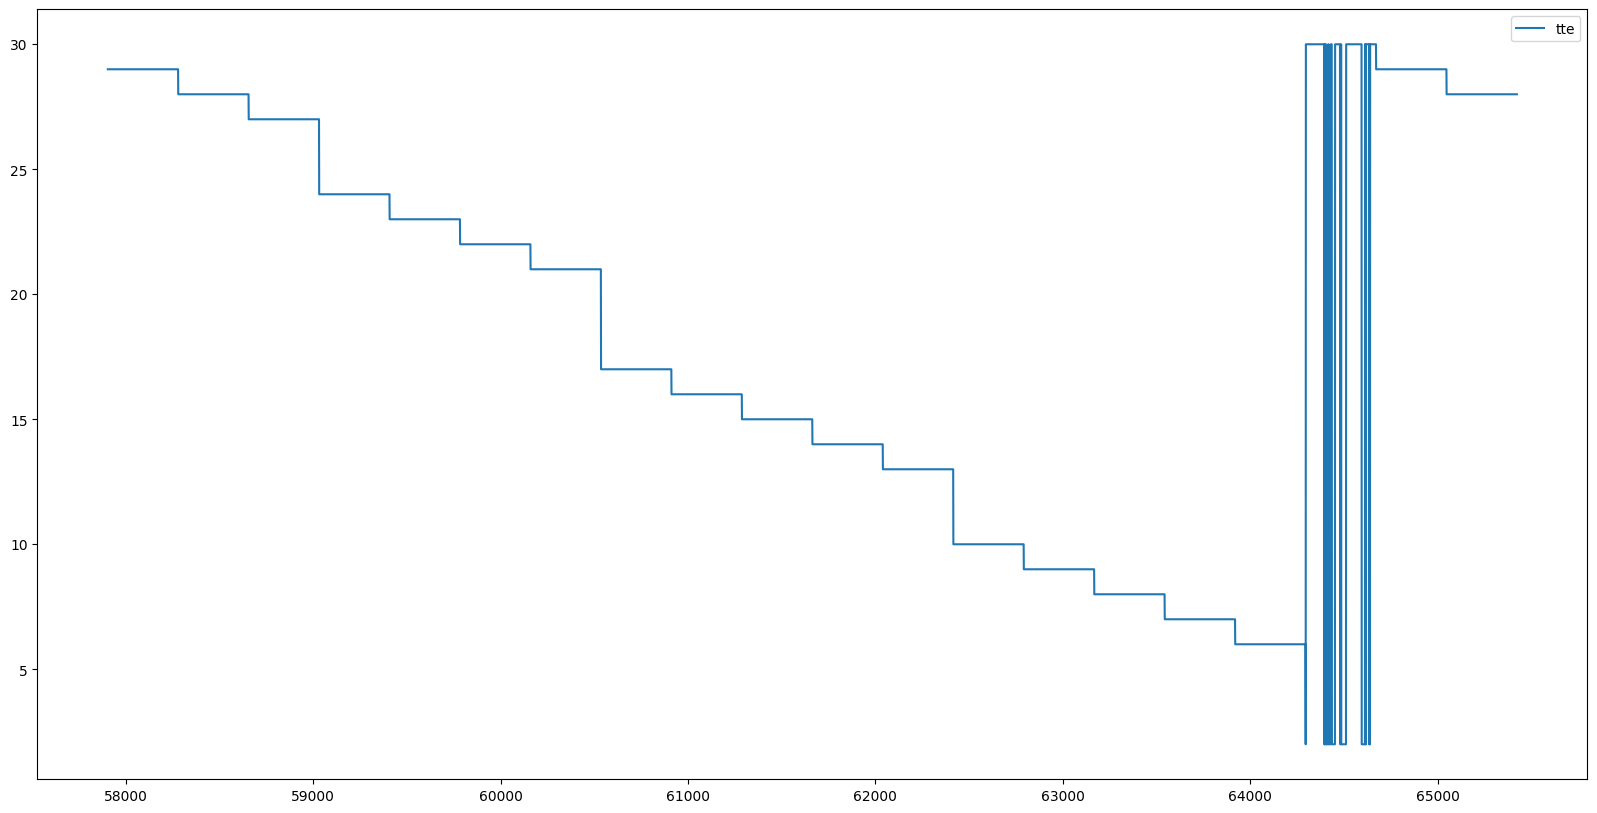

In [74]:
df['date'] = pd.to_datetime(df['date'])
# plot tte column for one month
df[df['date'].dt.month == 9].plot(y='tte', figsize=(20,10))


Looks like at the month end the tte oscillates

Something like this


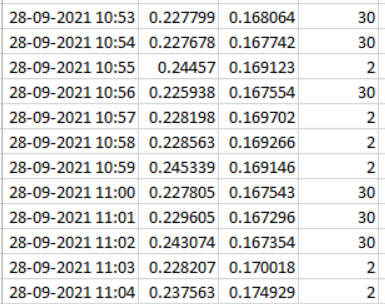

Felt like sharing this.